In [1]:
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk

### Data Understanding & Cleaning

In [2]:
main_data = pd.read_csv('nyt-articles-2020.csv')

In [3]:
main_data.head()

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...


In [4]:
article_titles = main_data['headline']
article_keywords = main_data['keywords']
article_headlines = main_data['abstract']

In [5]:
#Add sentiment value for both title and headline(abstract)

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

sid = SentimentIntensityAnalyzer()
title_sentiment = [sid.polarity_scores(str(title))['compound'] for title in article_titles]
headline_sentiment = [sid.polarity_scores(str(headline))['compound'] for headline in article_headlines]

main_data['titleSentiment'] = title_sentiment
main_data['headlineSentiment'] = headline_sentiment

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

def tokenize(article_titles):
    titles_list = [str(title) for title in article_titles]

    # Collapse the list of strings into a single long string for processing
    big_title_string = ' '.join(titles_list)

    # Tokenize the string into words
    tokens = word_tokenize(big_title_string)

    # Remove non-alphabetic tokens, such as punctuation
    words = [word.lower() for word in tokens if word.isalpha()]


    words = [word for word in words if not word in stop_words]
    
    # Print first 10 words
    print(words[:10])
    
    return titles_list, words

In [7]:
titles_list, title_words = tokenize(article_titles)
keywords_list, keyword_words = tokenize(article_keywords)
headlines_list = [str(headline) for headline in article_headlines]

['protect', 'veterans', 'fraud', 'green', 'slimy', 'meteor', 'showers', 'light', 'night', 'skies']
['schools', 'aid', 'education', 'swindling', 'universities', 'affairs', 'department', 'trade', 'commission', 'phoenix']


In [8]:
# Load Word2Vec model (trained on an enormous Google corpus)
filename = 'GoogleNews-vectors-negative300.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary = True) 

# Check dimension of word vectors
model.vector_size

300

In [9]:
title_vector_list = [model[word] for word in title_words if word in model.vocab]
keyword_vector_list = [model[word] for word in keyword_words if word in model.vocab]

# Create a list of the words corresponding to these vectors
title_words_filtered = [word for word in title_words if word in model.vocab]
keyword_words_filtered = [word for word in keyword_words if word in model.vocab]

# Zip the words together with their vector representations
title_word_vec_zip = zip(title_words_filtered, title_vector_list)
keyword_word_vec_zip = zip(keyword_words_filtered, keyword_vector_list)
word_vec_zip = list(title_word_vec_zip)+list(keyword_word_vec_zip)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

(16108, 300)

In [10]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
protect,-0.180664,0.179688,-0.148438,-0.103027,-0.341797,0.091309,0.137695,0.223633,0.197266,0.128906,...,0.040771,0.037109,-0.125977,-0.049072,-0.203125,0.249023,-0.119629,-0.100586,0.108887,-0.171875
veterans,0.062500,0.406250,-0.113770,0.203125,0.086426,-0.279297,-0.172852,-0.070312,-0.052246,-0.089355,...,0.201172,-0.018311,-0.232422,-0.024048,0.163086,-0.085449,-0.097168,-0.131836,0.113281,-0.116699
fraud,-0.009338,0.235352,-0.029663,-0.090820,0.088867,0.209961,0.042480,-0.064453,0.142578,-0.375000,...,-0.060547,0.029053,-0.084961,0.021606,0.250000,0.149414,-0.044189,-0.199219,0.004486,-0.249023


In [11]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [12]:
# Preprocess the corpus
corpus = [preprocess(title)+preprocess(keyword) for title,keyword in zip(titles_list,keywords_list)]
print(corpus[0])
# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

['protect', 'veterans', 'fraud', 'schools', 'aid', 'education', 'swindling', 'universities', 'affairs', 'department', 'trade', 'commission', 'phoenix', 'education', 'corporation']
2 docs removed
0 docs removed


In [13]:
# Preprocess the corpus
corpus = [preprocess(title)+preprocess(keyword) for title,keyword in zip(titles_list,keywords_list)]
print(corpus[0])
# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

['protect', 'veterans', 'fraud', 'schools', 'aid', 'education', 'swindling', 'universities', 'affairs', 'department', 'trade', 'commission', 'phoenix', 'education', 'corporation']
0 docs removed
0 docs removed


In [14]:
main_data = main_data.drop(main_data.index[main_data.n_comments.apply(lambda x: str(x).isdigit()==False or x<0)])
main_data.head()

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID,titleSentiment,headlineSentiment
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,-0.296,0.4364
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...,0.000,0.0000
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...,0.000,0.0000
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...,0.000,0.1139
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...,0.000,-0.2023


### Data Analysis

In [15]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

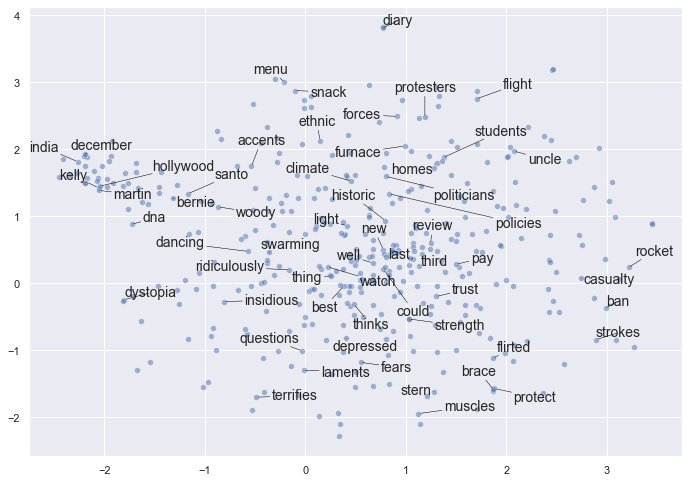

In [16]:
sns.set()

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 7))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

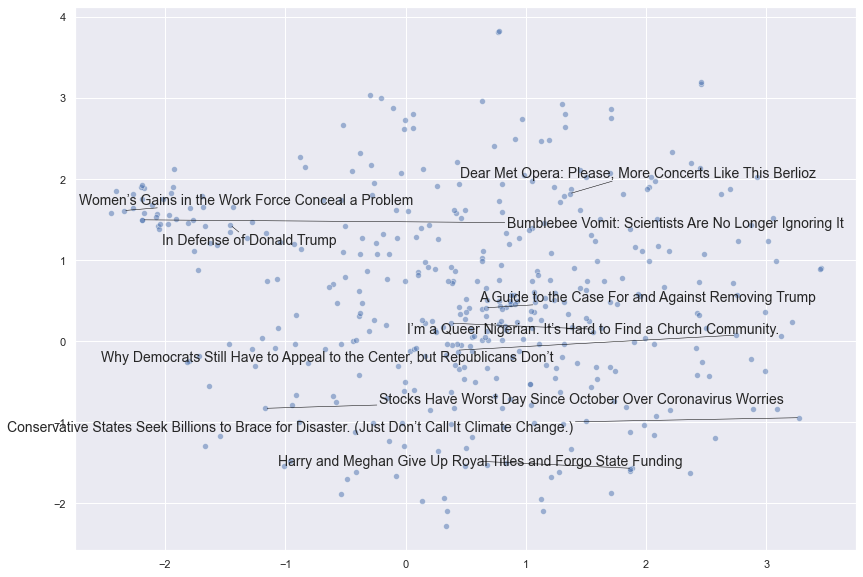

In [17]:
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[800+title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

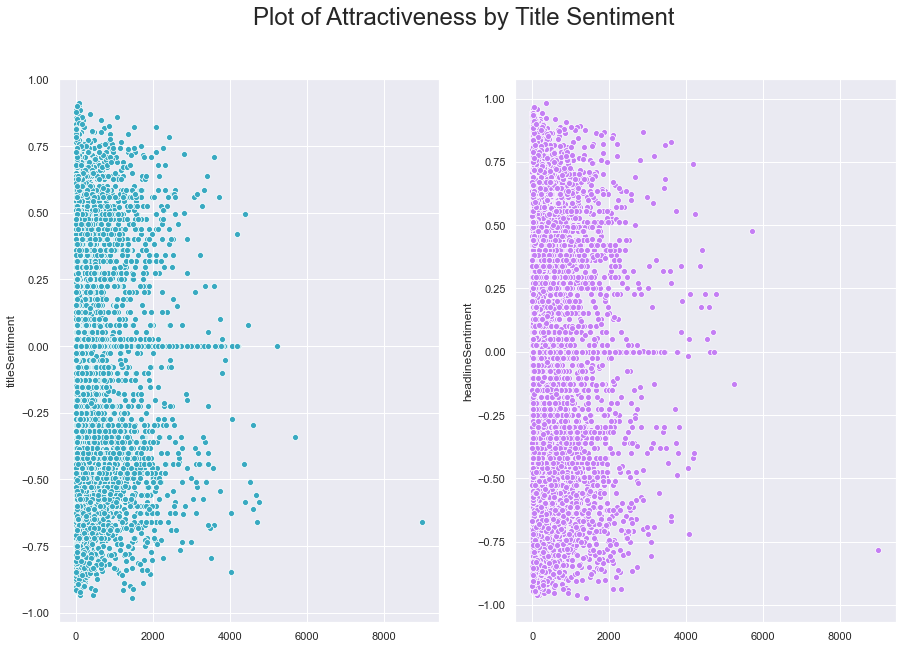

count    16787.000000
mean       297.043009
std        513.406953
min          1.000000
25%         21.000000
50%         87.000000
75%        323.000000
max       8987.000000
Name: n_comments, dtype: float64

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

subplots = [a for a in ax]
colors = sns.husl_palette(10, h=.5)[1:4] 


sns.scatterplot(x = main_data['n_comments'], y = main_data['titleSentiment'], ax=subplots[0], color=colors[0])
sns.scatterplot(x = main_data['n_comments'], y = main_data['headlineSentiment'], ax=subplots[1], color=colors[2])
subplots[0].set_xlabel('')
subplots[1].set_xlabel('') 
    
fig.suptitle('Plot of Attractiveness by Title Sentiment', fontsize=24)

plt.show()

main_data['n_comments'].describe()

### Regression

In [19]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
X = np.array(x) # list to array

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15, random_state=10)

# x is the array with our 300-dimensional vectors
reduced_vecs = pca.fit_transform(x)

In [21]:
main_data = main_data.drop(main_data.index[main_data.n_comments.apply(lambda x: str(x).isdigit()==False or x<0)])
main_data.head()

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID,titleSentiment,headlineSentiment
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,-0.296,0.4364
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...,0.000,0.0000
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...,0.000,0.0000
3,Science,Science,NaN,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...,0.000,0.1139
4,Science,Science,NaN,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...,0.000,-0.2023


In [22]:
df_w_vectors = pd.DataFrame(reduced_vecs)

df_w_vectors['headline'] = titles_list
main_w_vectors = pd.concat((df_w_vectors, main_data), axis=1)

In [23]:
# All of the columns have been successfully appended 
list(main_w_vectors.columns)[15:]

['headline',
 'newsdesk',
 'section',
 'subsection',
 'material',
 'headline',
 'abstract',
 'keywords',
 'word_count',
 'pub_date',
 'n_comments',
 'uniqueID',
 'titleSentiment',
 'headlineSentiment']

In [24]:
cols_to_drop = ['newsdesk', 'headline', 'subsection', 'material', 'keywords', 'abstract', 'word_count', 'pub_date', 'uniqueID','section'] 
data_only_df = main_w_vectors.drop(columns=cols_to_drop)

# Get rid of vectors that couldn't be matched with the main_df
data_only_df.dropna(axis=0, inplace=True)
data_only_df.head()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,n_comments,titleSentiment,headlineSentiment
0,-0.293061,-0.331070,-0.117539,-0.188282,-0.002005,-0.020131,-0.035678,-0.232612,0.014447,0.107649,-0.017610,-0.125012,0.097533,0.165011,0.112131,186,-0.296,0.4364
1,-0.059511,0.601819,0.411033,-0.018567,0.735086,0.414330,0.198774,-0.111695,-0.159868,-0.234151,-0.064922,0.066930,-0.063265,0.081558,-0.006510,257,0.000,0.0000
2,-0.288005,0.286641,-0.049340,0.088073,-0.049225,0.046637,-0.012343,0.321681,0.256599,0.148914,-0.239740,0.338576,0.194452,0.461092,-0.409628,6,0.000,0.0000
3,-0.384624,0.123406,-0.011505,-0.046682,0.247233,-0.061515,-0.059589,0.109544,0.182947,0.249570,-0.073736,0.197995,0.216072,0.314351,-0.308253,2,0.000,0.1139
4,-0.036587,0.152760,-0.050265,-0.025840,0.182581,-0.048601,-0.146051,-0.179259,0.241794,0.108275,-0.201795,0.128215,0.050759,0.453005,-0.181829,25,0.000,-0.2023


In [25]:
from sklearn.model_selection import train_test_split
X = data_only_df.drop('n_comments', axis=1)
y = data_only_df['n_comments']
# 80% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [26]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)
y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

217071.3611965357

In [27]:
from sklearn.model_selection import GridSearchCV

# Various hyper-parameters to tune
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [250]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[17:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.25158891890336876
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [28]:
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 
          'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

# Try again with new params
xgr = xgb.XGBRegressor(random_state=2, **params)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

[17:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:56:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




197191.63534842143

In [29]:
#chekck the weight for each feature
for feature, importance in zip(list(X.columns), xgr.feature_importances_):
    print('Model weight for feature {}: {}'.format(feature, importance))

Model weight for feature 0: 0.06439995765686035
Model weight for feature 1: 0.1616116315126419
Model weight for feature 2: 0.09158138185739517
Model weight for feature 3: 0.05249505862593651
Model weight for feature 4: 0.056278154253959656
Model weight for feature 5: 0.04121753200888634
Model weight for feature 6: 0.07093488425016403
Model weight for feature 7: 0.046167079359292984
Model weight for feature 8: 0.07069128751754761
Model weight for feature 9: 0.042085547000169754
Model weight for feature 10: 0.042192716151475906
Model weight for feature 11: 0.036521945148706436
Model weight for feature 12: 0.05432853847742081
Model weight for feature 13: 0.03299971669912338
Model weight for feature 14: 0.03718441724777222
Model weight for feature titleSentiment: 0.052335068583488464
Model weight for feature headlineSentiment: 0.04697509855031967


### Classification

In [30]:
data_only_df['n_comments'].describe()

count    16785.000000
mean       297.053738
std        513.436031
min          1.000000
25%         21.000000
50%         87.000000
75%        323.000000
max       8987.000000
Name: n_comments, dtype: float64

In [31]:
def dud_finder(popularity):
    if popularity <= 17:
        return 1
    else:
        return 0

# Create target column using the function
data_only_df['is_dud'] = data_only_df['n_comments'].apply(dud_finder)
data_only_df[['n_comments','is_dud']].head()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,n_comments,is_dud
0,186,0
1,257,0
2,6,1
3,2,1
4,25,0


In [32]:
data_only_df['is_dud'].value_counts()

0    13063
1     3722
Name: is_dud, dtype: int64

In [33]:
# 22% of articles can be classified as "duds"
data_only_df['is_dud'].sum() / len(data_only_df)

0.22174560619600833

In [34]:
X = data_only_df.drop('is_dud', axis=1)
y = data_only_df['is_dud']

# 80% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [35]:
# Hyper-parameters to tune
xgc = xgb.XGBClassifier()
parameters = {'nthread':[4],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'verbosity': [0],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100]}

xgb_grid = GridSearchCV(xgc,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


1.0
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'nthread': 4, 'subsample': 0.7, 'verbosity': 0}


In [36]:
# Give it 200 estimators, 100 is just a restriction to make the grid search run faster
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 
          'n_estimators': 200, 'nthread': 4, 'silent': 1, 'subsample': 0.7}

# Try again with new params
xgc = xgb.XGBClassifier(random_state=10, **params)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X = data_only_df.drop(['is_dud', 'n_comments'], axis=1)
y = data_only_df['is_dud']

# 70% of data goes to training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

#lr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=10)
#xgc = xgb.XGBClassifier(random_state=10)
rfc = RandomForestClassifier(n_estimators=100, random_state=10)
knn = KNeighborsClassifier()
svc = SVC()

preds = {}
for model_name, model in zip(['XGClassifier', 'RandomForestClassifier', 'KNearestNeighbors', 'SVC'], [xgc, rfc, knn, svc]):
    model.fit(X_train, y_train)
    preds[model_name] = model.predict(X_test)

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [38]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

for k in preds:
    print("{} performance:".format(k))
    print()
    print(classification_report(y_test, preds[k]), sep='\n')

XGClassifier performance:

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      2615
           1       0.59      0.15      0.24       742

    accuracy                           0.79      3357
   macro avg       0.69      0.56      0.56      3357
weighted avg       0.75      0.79      0.74      3357

RandomForestClassifier performance:

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      2615
           1       0.64      0.17      0.27       742

    accuracy                           0.80      3357
   macro avg       0.72      0.57      0.57      3357
weighted avg       0.77      0.80      0.75      3357

KNearestNeighbors performance:

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2615
           1       0.47      0.29      0.36       742

    accuracy                           0.77      3357
   macro avg       0.64      0.6

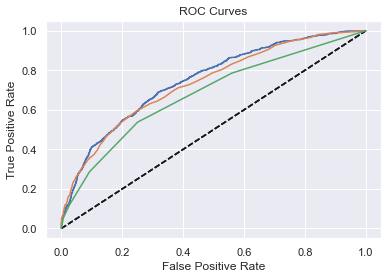

In [39]:
# Plot ROC curves
sns.set()

for model_name, model in zip(['XGClassifier', 'RandomForestClassifier', 'KNearestNeighbors'], [xgc, rfc, knn]):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

###  Classification-Round2

In [40]:
# Now we can add the averaged probabilities that each article is a dud to help out the regressor
averaged_probs = (xgc.predict_proba(X)[:, 1] +
                  knn.predict_proba(X)[:, 1] + 
                  rfc.predict_proba(X)[:, 1]) / 3

In [41]:
X['prob_dud'] = averaged_probs
y = data_only_df['n_comments']

# Reinitialize the train_test_split since we've changed back to regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

# Another round of hyperparameter tuning
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, .05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'verbosity': [0],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [250]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.2896811515055438
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.7, 'verbosity': 0}


In [42]:
params = {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 
          'n_estimators': 250, 'nthread': 4, 'objective': 'reg:linear', 'verbosity': 0, 'subsample': 0.7}

# Try again with new params
xgr = xgb.XGBRegressor(random_state=2, **params)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=6,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=2, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [43]:
y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

197471.2480746314

In [44]:
doc_vector_weight = 0
feature_list = ['doc_vector','titleSentiment', 'headlineSentiment', 'prob_dud']
weight_list = []
for feature, importance in zip(list(X.columns), xgr.feature_importances_):
    if type(feature) == int:
        doc_vector_weight +=importance
        if feature == 14:
            weight_list.append(doc_vector_weight)
    else:
        weight_list.append(importance)
    print('Model weight for feature {}: {}'.format(feature, importance))

Model weight for feature 0: 0.059500712901353836
Model weight for feature 1: 0.09268082678318024
Model weight for feature 2: 0.06741351634263992
Model weight for feature 3: 0.05424977093935013
Model weight for feature 4: 0.043646328151226044
Model weight for feature 5: 0.03677085414528847
Model weight for feature 6: 0.05562828108668327
Model weight for feature 7: 0.04490787908434868
Model weight for feature 8: 0.05219819396734238
Model weight for feature 9: 0.04000227525830269
Model weight for feature 10: 0.04513977840542793
Model weight for feature 11: 0.03152154013514519
Model weight for feature 12: 0.0498025082051754
Model weight for feature 13: 0.03548329323530197
Model weight for feature 14: 0.04259626194834709
Model weight for feature titleSentiment: 0.04490825906395912
Model weight for feature headlineSentiment: 0.046213336288928986
Model weight for feature prob_dud: 0.15733642876148224


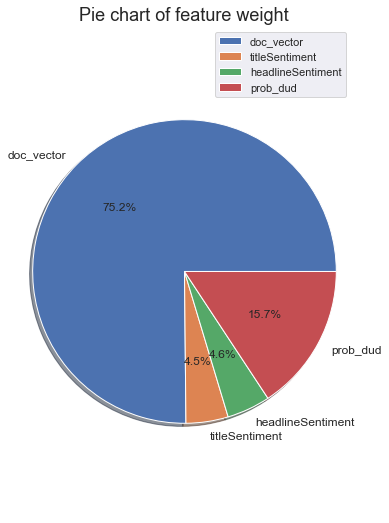

In [45]:
plt.figure(figsize=(6,9))  

labels = feature_list     
separeted = (0, 0.25, 0.25, 0.5)                  
size = weight_list                        

plt.pie(size,                           
        labels = labels,                
        autopct = "%1.1f%%",            
#        explode = separeted,           
        pctdistance = 0.6,              
        textprops = {"fontsize" : 12},  
        shadow=True)                    

 
plt.axis('equal')                                          
plt.title("Pie chart of feature weight", {"fontsize" : 18})  
plt.legend(loc = "best")                                   

#plt.savefig("weight.jpg",   
#            bbox_inches='tight',               
#            pad_inches=0.0)                    
plt.show() 